In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [2]:
## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Al" 
_path = datapath + "bananas/" + iso
above_path = datapath+ "aboveban/" + iso
cuts1 = datapath + "cuts/totcuts.root"
outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
#above_files = glob.glob(os.path.join(above_path, "*mlio.root"))

In [3]:
#### Loading in of the data files storing them in a dictionary
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    "Al": _files,
}
data_collection = {
    "Al" : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "Ea", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "Ea", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        Eas = ak.nan_to_num(ak.flatten(dum["Ea"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["Ea"].extend(Eas[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Al:   0%|           0/50 [00:00<?, ?file/s]

Processing Al: 100%|██████████ 50/50 [00:39<00:00,  1.25file/s]


In [4]:
## loading in cuts and sorting the data to only look into specific cut regions
totcuts = uproot.open(cuts1)

xsa =[]
ysa =[]
for i in ["abovebanU1", "abovebanU2", "abovebanU3"]:
    x, y = totcuts[i].values()
    xsa.append(np.array(x)/1e3)
    ysa.append(np.array(y)/1e3)
xs =[]
ys =[]
for i in ["bananaU1", "bananaU2", "bananaU3"]:
    
    x, y = totcuts[i].values()
    xs.append(np.array(x)/1e3)
    ys.append(np.array(y)/1e3)
   
in_fedep = []
in_bedep = []
in_E = []
above_events = []
above_fedep = []
above_bedep = []
above_E = []

isotope = iso
for k, i, j, l, h in zip(range(0,3),xs,ys, xsa, ysa):
    det = f"id{k}"
    inbanana = np.column_stack((i, j))
    abovebanana = np.column_stack((l, h))
    abovebanana_path = Path(abovebanana)
    inbanana_path = Path(inbanana)
    points = np.column_stack((data_collection[isotope][det]["bEdep"], data_collection[isotope][det]["fEdep"]))
    inmask = inbanana_path.contains_points(points)
    abovemask = abovebanana_path.contains_points(points)

    
    
    above_E.append(np.array(data_collection[isotope][det]["E"])[abovemask])
    above_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[abovemask])
    above_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[abovemask])
    in_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[inmask])
    in_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[inmask])
    in_E.append(np.array(data_collection[isotope][det]["E"])[inmask])
    above_events.append(len(above_fedep[k]))


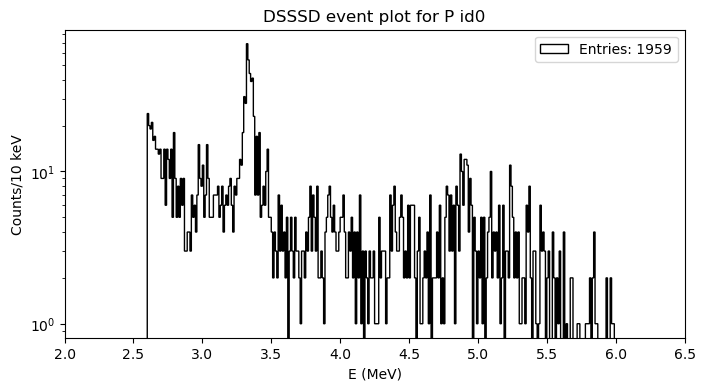

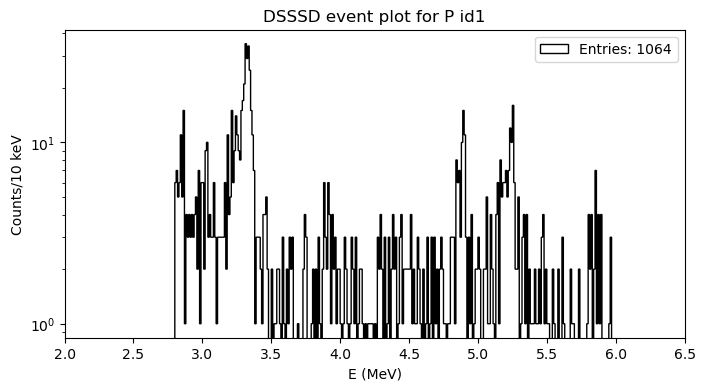

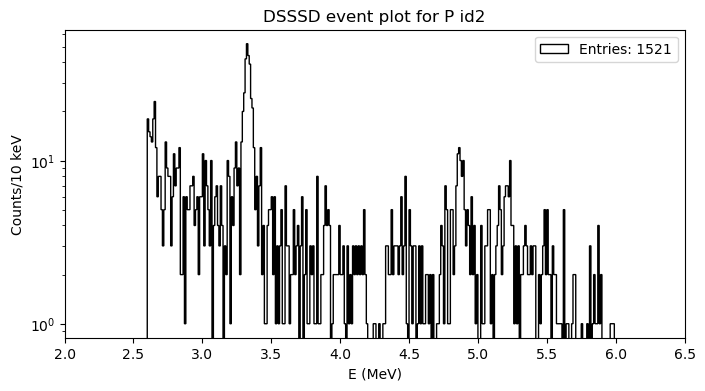

In [5]:
#### Same plots as above, now i have plotted for the energy above the range of the expected protons
for i in range(3):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    e = np.array(data_collection[iso][det]["Ea"])
    if det=="id1":
        e = e[e>2.8]
    else:
        e = e[e>2.6]
    plt.hist(e, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts/10 keV")
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlim(2, 6.5)
    plt.title(f"DSSSD event plot for P {det}")
    plt.savefig(outputdir +f"ALdsdeventplot{det}")

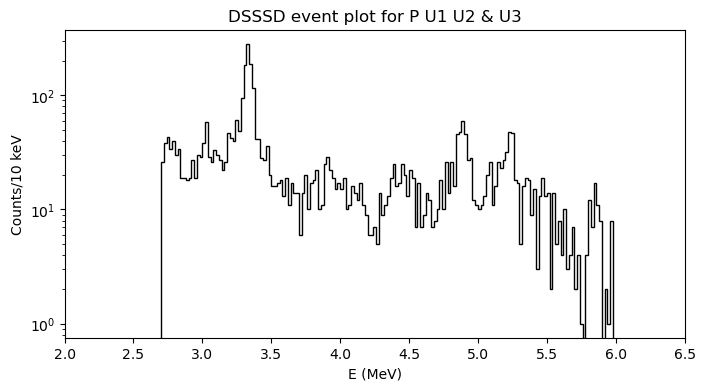

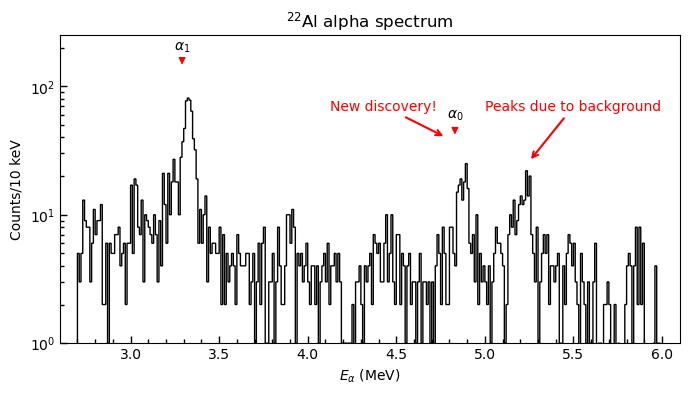

In [6]:
### combination DSSSD plots of U1-U3 and U2-U3
es = []
plt.figure(figsize=(8,4))
for i in range(3):
    det = f"id{i}"
    e = [j for j in data_collection[iso][det]["Ea"] if det=="id1" and j>3 or det!="id1" and j>2.7]
    es+=e
#e = e[e>0.5]
plt.hist(es, bins=np.arange(0, 6, 0.02), histtype='step', color='k', label=f"Entries: {len(e)}")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 keV")
plt.yscale('log')
plt.xlim(2, 6.5)
plt.title(f"DSSSD event plot for P U1 U2 & U3")
plt.savefig(outputdir + "AlDSSSDeventall.png")

Es= []
plt.figure(figsize=(8,4))
for det in ["id1", "id2"]:
    for j in data_collection[iso][det]["Ea"]:
        if (det == "id2" and j > 2.7) or (det == "id1" and j > 3):
            Es.append(j)

#e = e[e>0.5]
plt.hist(Es, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
plt.xlabel(r"$E_{\alpha}$ (MeV)")
plt.ylabel("Counts/10 keV")
plt.yscale('log')
plt.xlim(2.6, 6.1)
plt.ylim(1,150+10**2)
plt.title(r"$^{22}$Al alpha spectrum")
plt.savefig(outputdir + "AlDSSSDevent12.png")
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.minorticks_on()

plt.annotate(r"$\alpha_1$", xy=(3.29, 140), xytext=(3.245, 190),
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='-|>'), fontsize=10)

plt.annotate(r"$\alpha_0$", xy=(4.83, 40), xytext=(4.785, 57),
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='-|>'), fontsize=10)
plt.annotate("New discovery!",
             xy=(4.78, 40),             # Point the arrow points to
             xytext=(4.43, 65),         # Text position
             arrowprops=dict(facecolor='white', edgecolor='red', arrowstyle="->", lw=1.5),
             fontsize=10, color='red', ha='center')

plt.annotate("Peaks due to background",
             xy=(5.25, 26),             # Point the arrow points to
             xytext=(5.5, 65),         # Text position
             arrowprops=dict(facecolor='white', edgecolor='red', arrowstyle="->", lw=1.5),
             fontsize=10, color='red', ha='center')

plt.savefig('Alalphas.pdf')

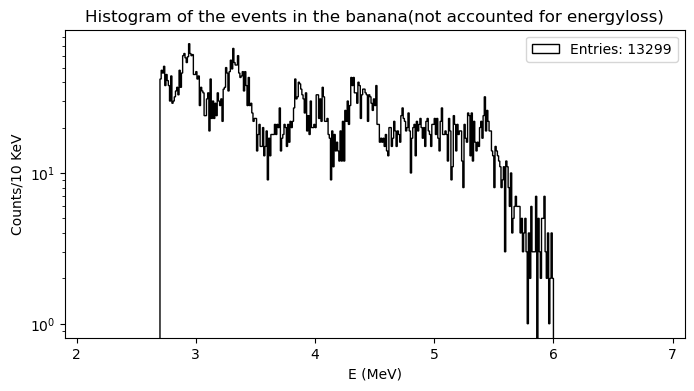

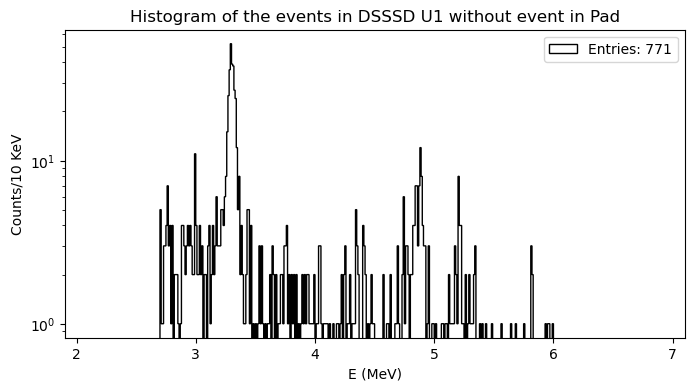

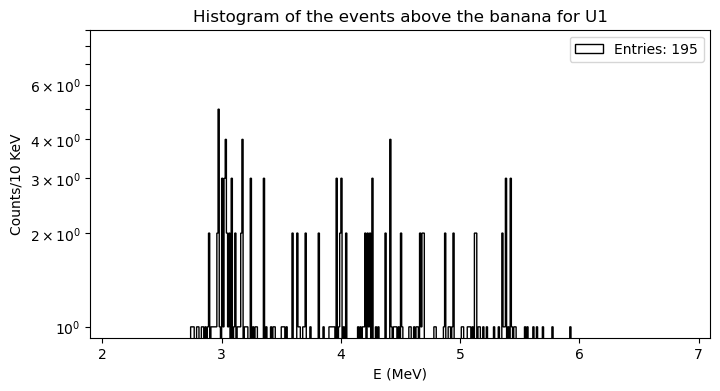

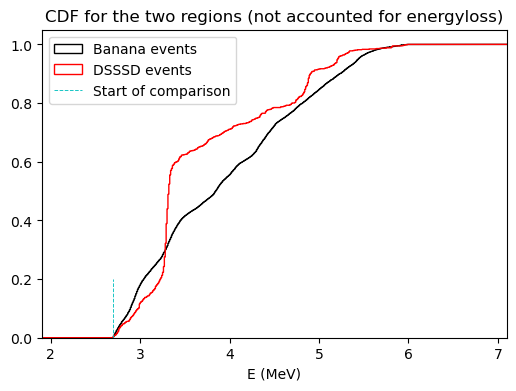

In [7]:
#### Different histograms of different regions and effects
## And a CDF plot of two distributions

sumE = [a+b for a,b in zip(in_fedep[0], in_bedep[0]) if 6>a+b>2.7]
plt.figure(figsize=(8,4))
plt.hist(sumE, bins=np.arange(0,8,0.01), histtype='step', color='k', label=f"Entries: {len(in_E[0])}")
plt.yscale('log')
plt.title("Histogram of the events in the banana(not accounted for energyloss)")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')
plt.savefig(outputdir + "AlU1bananahist.png")



#plt.show()
g = len(data_collection[iso]["id0"]["Edep"])
#plot of events recorded above the banana
sume = [a for a in data_collection[iso]["id0"]["Edep"] if 6>a>2.7]
plt.figure(figsize=(8,4))
plt.hist(sume, bins=np.arange(0, 8, 0.01), histtype='step', color='k', label=f"Entries: {len(sume)}")
plt.yscale('log')
plt.title("Histogram of the events in DSSSD U1 without event in Pad")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')

#plot of events recorded above the banana
abovesum = [a+b for a,b in zip(above_fedep[0], above_bedep[0]) if 6>a+b>2.7]
plt.figure(figsize=(8,4))
plt.hist(abovesum, bins=np.arange(0, 8, 0.01), histtype='step', color='k', label=f"Entries: {len(abovesum)}")
plt.yscale('log')
plt.title("Histogram of the events above the banana for U1")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')
plt.yticks(np.arange(1, 10, 1))

plt.figure(figsize=(6,4))
plt.hist(sumE, bins=np.arange(0,8,0.01), histtype='step', color='k', cumulative=True, label="Banana events", density=True)
plt.hist(sume, bins=np.arange(0,8,0.01), histtype='step', color='r', cumulative=True, label="DSSSD events", density=True)
plt.vlines(2.7, 0, 0.2, color='c', alpha=0.9, lw=0.7, ls='--', label="Start of comparison")
plt.xlabel("E (MeV)")
plt.legend(loc='upper left')
plt.xlim(0,8.5)
plt.xticks(np.arange(0,9,1))
plt.title("CDF for the two regions (not accounted for energyloss)")
plt.xlim(1.9, 7.1)
plt.savefig(outputdir + "AlCDF.png")

Entries with FI>8.5: 319
Entries with FI<8.5: 543
Entries with FI>8.5: 238
Entries with FI<8.5: 222
Entries with FI>8.5: 231
Entries with FI<8.5: 256


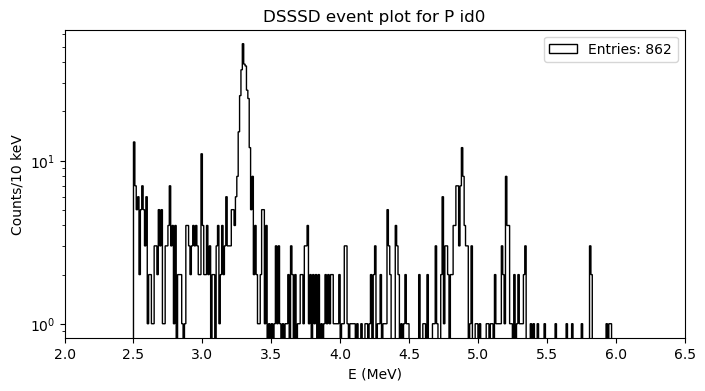

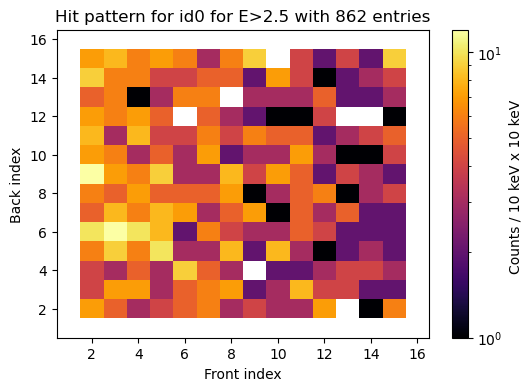

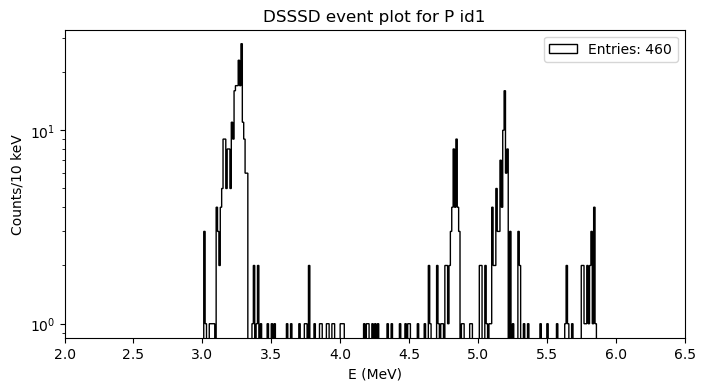

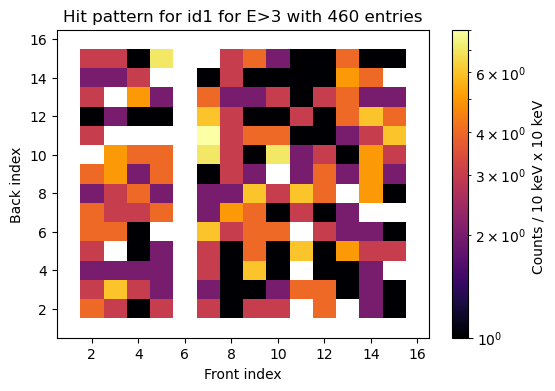

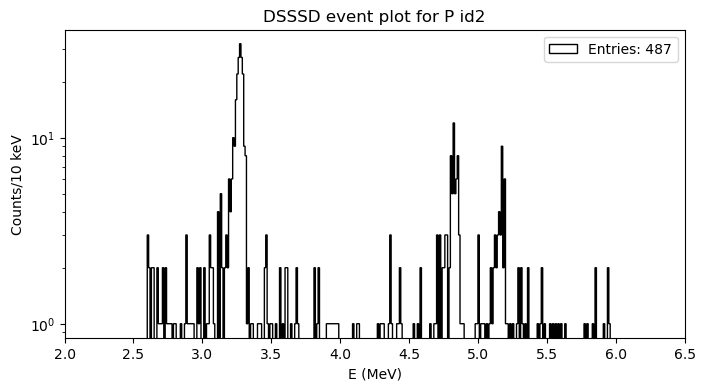

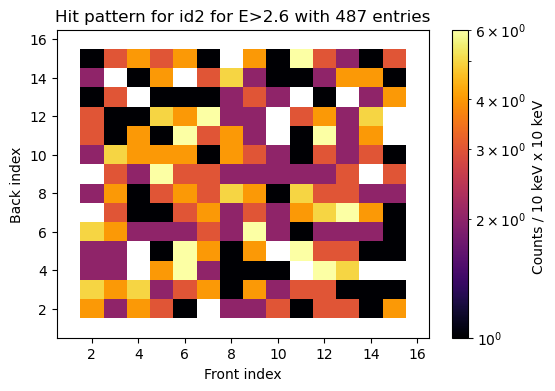

In [8]:
###The DSSSD plots along with the hit pattern that shows where the events shown in the spectrum have hit the detector
for i in range(3):
    plt.figure(figsize=(8,4))
    det = f"id{i}"
    e = np.array(data_collection[iso][det]["Edep"])
    fi = np.array(data_collection[iso][det]["FI"])
    bi = np.array(data_collection[iso][det]["BI"])
    if det=="id1":
        lim = 3
        mask = (e>lim)
        e = e[mask]
        fi = fi[mask]
        bi = bi[mask]
    if det =="id0":
        lim = 2.5
        mask = (e>lim)
        e = e[mask]
        fi = fi[mask]
        bi = bi[mask]
    if det=="id2":
        lim = 2.6
        mask = (e>lim)
        e = e[mask]
        fi = fi[mask]
        bi = bi[mask]    
    plt.hist(e, bins=np.arange(0, 6, 0.01), histtype='step', color='k', label=f"Entries: {len(e)}")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts/10 keV")
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.xlim(2, 6.5)
    plt.title(f"DSSSD event plot for P {det}")
    plt.figure(figsize=(6,4))
    plt.hist2d(fi-0.5, bi-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for {det} for E>{lim} with {len(fi)} entries")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.savefig(outputdir + f"Alhitpat{det}.png")
    fo = [f for f in fi if f>8.5]
    fu = [f for f in fi if f<8.5] 
    print(f"Entries with FI>8.5: {len(fo)}")
    print(f"Entries with FI<8.5: {len(fu)}")